In [68]:
from pycaret.clustering import *

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [69]:
cnxn = pyodbc.connect(
    driver='{iSeries Access ODBC Driver}',
    system='192.168.100.2',
    uid='TBLPRDUSR',
    pwd='bbbb')
cursor = cnxn.cursor()
#cnxn.close()

In [70]:
#Cargue de la data desde el ERP de Dispapeles y se guarda en df
cursor.execute('SELECT DSTCOD AS "Codigo distrito", VTAZNA AS "Codigo zona", VTANIT AS "Nit cliente", ((2022 - LEFT(MAX(VTAFCH),4)) * 12 ) + (6 - SUBSTRING(MAX(VTAFCH),5,2)) AS "Recency", SUM(A.VTAVLRVTA) AS "Monetary", COUNT( DISTINCT LEFT(VTAFCH, 6)) AS "Frequency" FROM SIDPRDDTA.VTAHEC A WHERE PRMCOD = 1 AND A.DSTCOD = 10 AND A.VTAZNA < 96 AND LEFT(VTAFCH,6) BETWEEN 202011 AND 202210 GROUP BY DSTCOD, VTAZNA, VTANIT')
rows = cursor.fetchall()
df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [71]:
#Se añade una key de Distrito-Zona para hacer mas facil la identificacion cuando se usa todo el pais
#Se genera la calificacion de Recency basado en los valores máximos
#Se divide por millón la columna Monetary para disminuir el rango de los valores
df['Distrito-Zona'] = df['Codigo distrito'].astype(str) + '-' + df['Codigo zona'].astype(str)
df['Recency'] = max(df['Recency'])-df['Recency']+1
df['Monetary'] = df['Monetary'] / 1000000

In [72]:
zonas = list(np.unique(df['Distrito-Zona']))
for z in zonas:
    shape_0 = len(df[df['Distrito-Zona'] == z])
    if shape_0 < 3:
        print(f"Se omite la zona {z}")
        zonas.remove(z)

Se omite la zona 10-82


In [73]:
list_pred = []

for z in zonas:
    df_zona = df[df['Distrito-Zona'] == z]
    df_X = df_zona[['Recency', 'Monetary', 'Frequency']].sort_values(by= ['Monetary','Recency', 'Frequency'])
    s = setup(df_X, normalize = False, verbose= False)
    model = create_model('kmeans', num_clusters= 5)
    df_pred = predict_model(model, data = df_zona)
    list_pred.append(df_pred)
    print(z)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8849,2543.8917,0.248,0,0,0


10-9


In [75]:
df_predicted = pd.concat(list_pred)
df_predicted

,Codigo distrito,Codigo zona,Nit cliente,Recency,Monetary,Frequency,Distrito-Zona,Cluster
0,10,1,14317512,5,0.574372,1,10-1,Cluster 1
1,10,1,17172243,24,32.35119945,14,10-1,Cluster 1
2,10,1,19173449,17,1.279167,2,10-1,Cluster 1
3,10,1,19322486,24,39.58834908,17,10-1,Cluster 1
4,10,1,23588105,18,19.28482092,3,10-1,Cluster 1
...,...,...,...,...,...,...,...,...
683,10,9,901276512,5,28.09068022,5,10-9,Cluster 0
684,10,9,901291985,4,1.791387,2,10-9,Cluster 0
685,10,9,901355632,11,0.64787,1,10-9,Cluster 0
686,10,9,901528604,24,102.03233168,9,10-9,Cluster 0


Text(0.5, 0, 'Frequency')

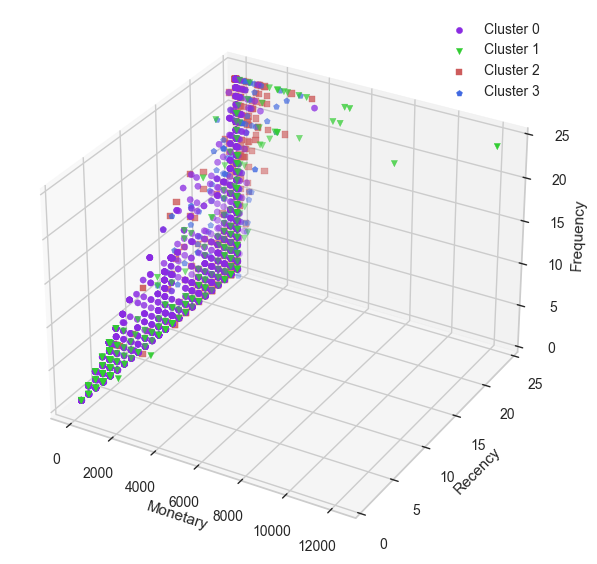

In [76]:
fig = plt.figure(figsize=(7,10))
ax = fig.gca(projection='3d')

m = ['o', 'v', 's', 'p', '*']
col =  ['blueviolet', 'limegreen', 'indianred', 'royalblue', 'magenta']
leg = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3']
cluster = list(np.unique(df_predicted['Cluster']))

for c in range(4):
    df_plot = df_predicted[df_predicted['Cluster'] == cluster[c]]
    ax.scatter(df_plot['Monetary'], df_plot['Recency'], df_plot['Frequency'], marker= m[c], c= col[c])
    
ax.legend(leg)
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

In [77]:
df_predicted[df_predicted['Distrito-Zona'] == '10-10']

,Codigo distrito,Codigo zona,Nit cliente,Recency,Monetary,Frequency,Distrito-Zona,Cluster
688,10,10,27602189,24,92.98001899,12,10-10,Cluster 4
689,10,10,51903957,21,3.08175,2,10-10,Cluster 3
690,10,10,74372895,23,7.272,1,10-10,Cluster 3
691,10,10,79208237,13,2.861958,1,10-10,Cluster 3
692,10,10,79263359,17,3.348082,1,10-10,Cluster 3
...,...,...,...,...,...,...,...,...
754,10,10,901538237,23,93.537627,7,10-10,Cluster 4
755,10,10,901553241,24,8.211971,4,10-10,Cluster 3
756,10,10,901569543,18,0.894824,1,10-10,Cluster 3
757,10,10,901581876,24,4.92107,3,10-10,Cluster 3


In [85]:
get_metrics(model)

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x0000025F7FE27670>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x0000025...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x0000025F7F...,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x0000025F7FE03...,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x0000025F7FE...,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x0000025F7FE0...,make_scorer(completeness_score),pred,{},True,True,False


In [79]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Cluster PCA Plot (2d)', …

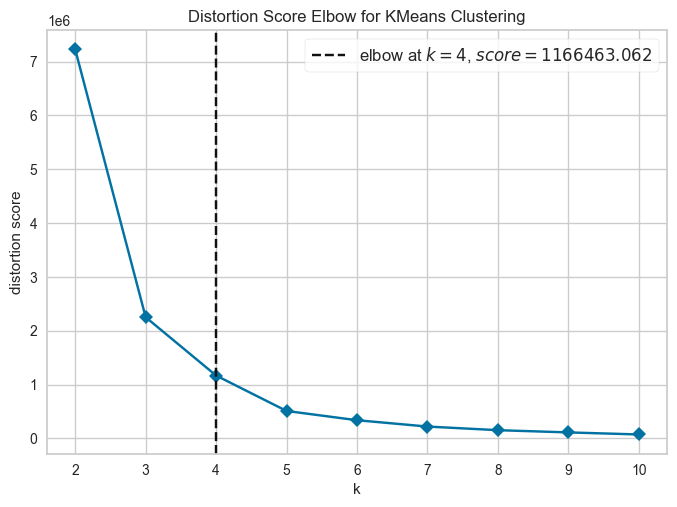

In [80]:
plot_model(model, plot = 'elbow')

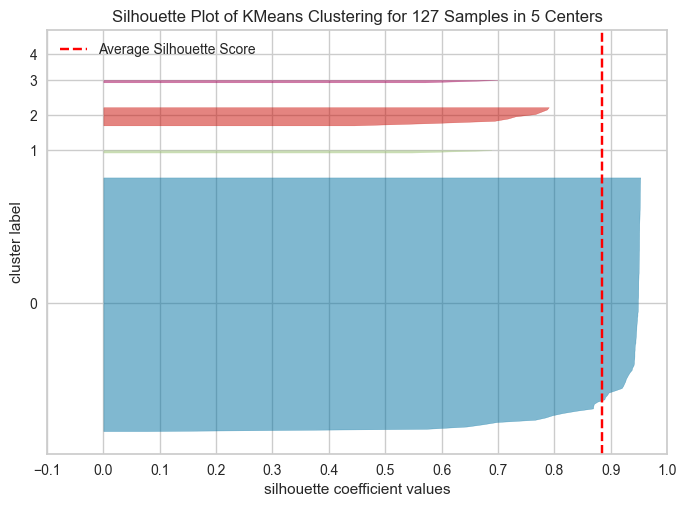

In [81]:
plot_model(model, plot = 'silhouette')